## Variable selection 5: Linear regression permutation importance

This notebook goes with the blog post: Variable selection in Python, part II.

### Preliminaries

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, make_scorer
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.linear_model import LinearRegression

### Data loading

In [2]:
data = pd.read_csv('../data/Table2_Hunt_2013_edit.csv')

In [3]:
data = data.loc[:, ['Production', 'Position', 'Gross pay', 'Phi-h', 'Pressure', 'Random 1', 'Random 2', 'Gross pay transform']]
data.head()

,Production,Position,Gross pay,Phi-h,Pressure,Random 1,Random 2,Gross pay transform
0,15.10,2.1,0.1,0.5,19,5,379,3.54
1,21.30,1.1,1.0,4.0,16,13,269,5.79
2,22.75,1.0,1.9,19.0,14,12,245,8.51
3,15.72,2.1,3.1,21.7,17,6,273,11.52
4,7.71,2.9,4.1,24.6,11,10,237,10.16


### Permutation importance using a linear regressor

A good explanation of Permutation importance can be found in the [Kaggle Machine Learning Explainability micro course](https://www.kaggle.com/dansbecker/permutation-importance).

In short, after a model has been fitted, a single column gets randomly shuffled, leaving the target and all other columns unchanged, and the performance loss gives a measure of importance of the column that was shuffled

In [4]:
import eli5
from eli5.sklearn import PermutationImportance

In [5]:
X, y = data.drop('Production',axis=1), data['Production']
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.4, random_state=99)

In [6]:
scorer = make_scorer(r2_score)

In [7]:
LR_fit = LinearRegression().fit(train_X, train_y)

In [8]:
perm = PermutationImportance(LR_fit, scoring = scorer, n_iter= 5, random_state=99).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.5959 ± 0.1048,Gross pay
0.2155 ± 0.0962,Position
0.1833 ± 0.0860,Phi-h
0.1045 ± 0.1025,Pressure
0.0378 ± 0.0288,Gross pay transform
0.0045 ± 0.0277,Random 2
0.0020 ± 0.0014,Random 1


### Permutation importance when production is either lower or greater than a certain cutoff
Let's say our minimum economic production cutoff is 20 (bbl/d x10)

In [18]:
idx1  = X.index[y>20].values
print (np.shape(idx1))

(17,)


In [19]:
X1=X.iloc[idx1]
y1=y[idx1]

In [47]:
train_X, val_X, train_y, val_y = train_test_split(X1, y1, test_size=0.4, random_state=99)
LR_fit1 = LinearRegression().fit(train_X, train_y)

In [48]:
perm = PermutationImportance(LR_fit1, scoring = scorer, n_iter= 5, random_state=99).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
3.0237 ± 1.7290,Gross pay
0.6088 ± 0.0553,Pressure
0.5085 ± 0.4519,Phi-h
0.2953 ± 0.1981,Position
0.2343 ± 0.1887,Gross pay transform
0.0246 ± 0.0322,Random 2
0.0002 ± 0.0015,Random 1


In [46]:
col         = 'Production'
#conditions  = [ data[col] >= 40, (data[col] < 40) & (data[col]> 20), data[col] <= 20]
#choices     = [ 'high', 'medium', 'low' ]
conditions  = [ data[col] >= 20, data[col] <= 20]
choices     = [ 'economic', 'sub-economic' ]

data['Production_classes'] = np.select(conditions, choices, default=np.nan)

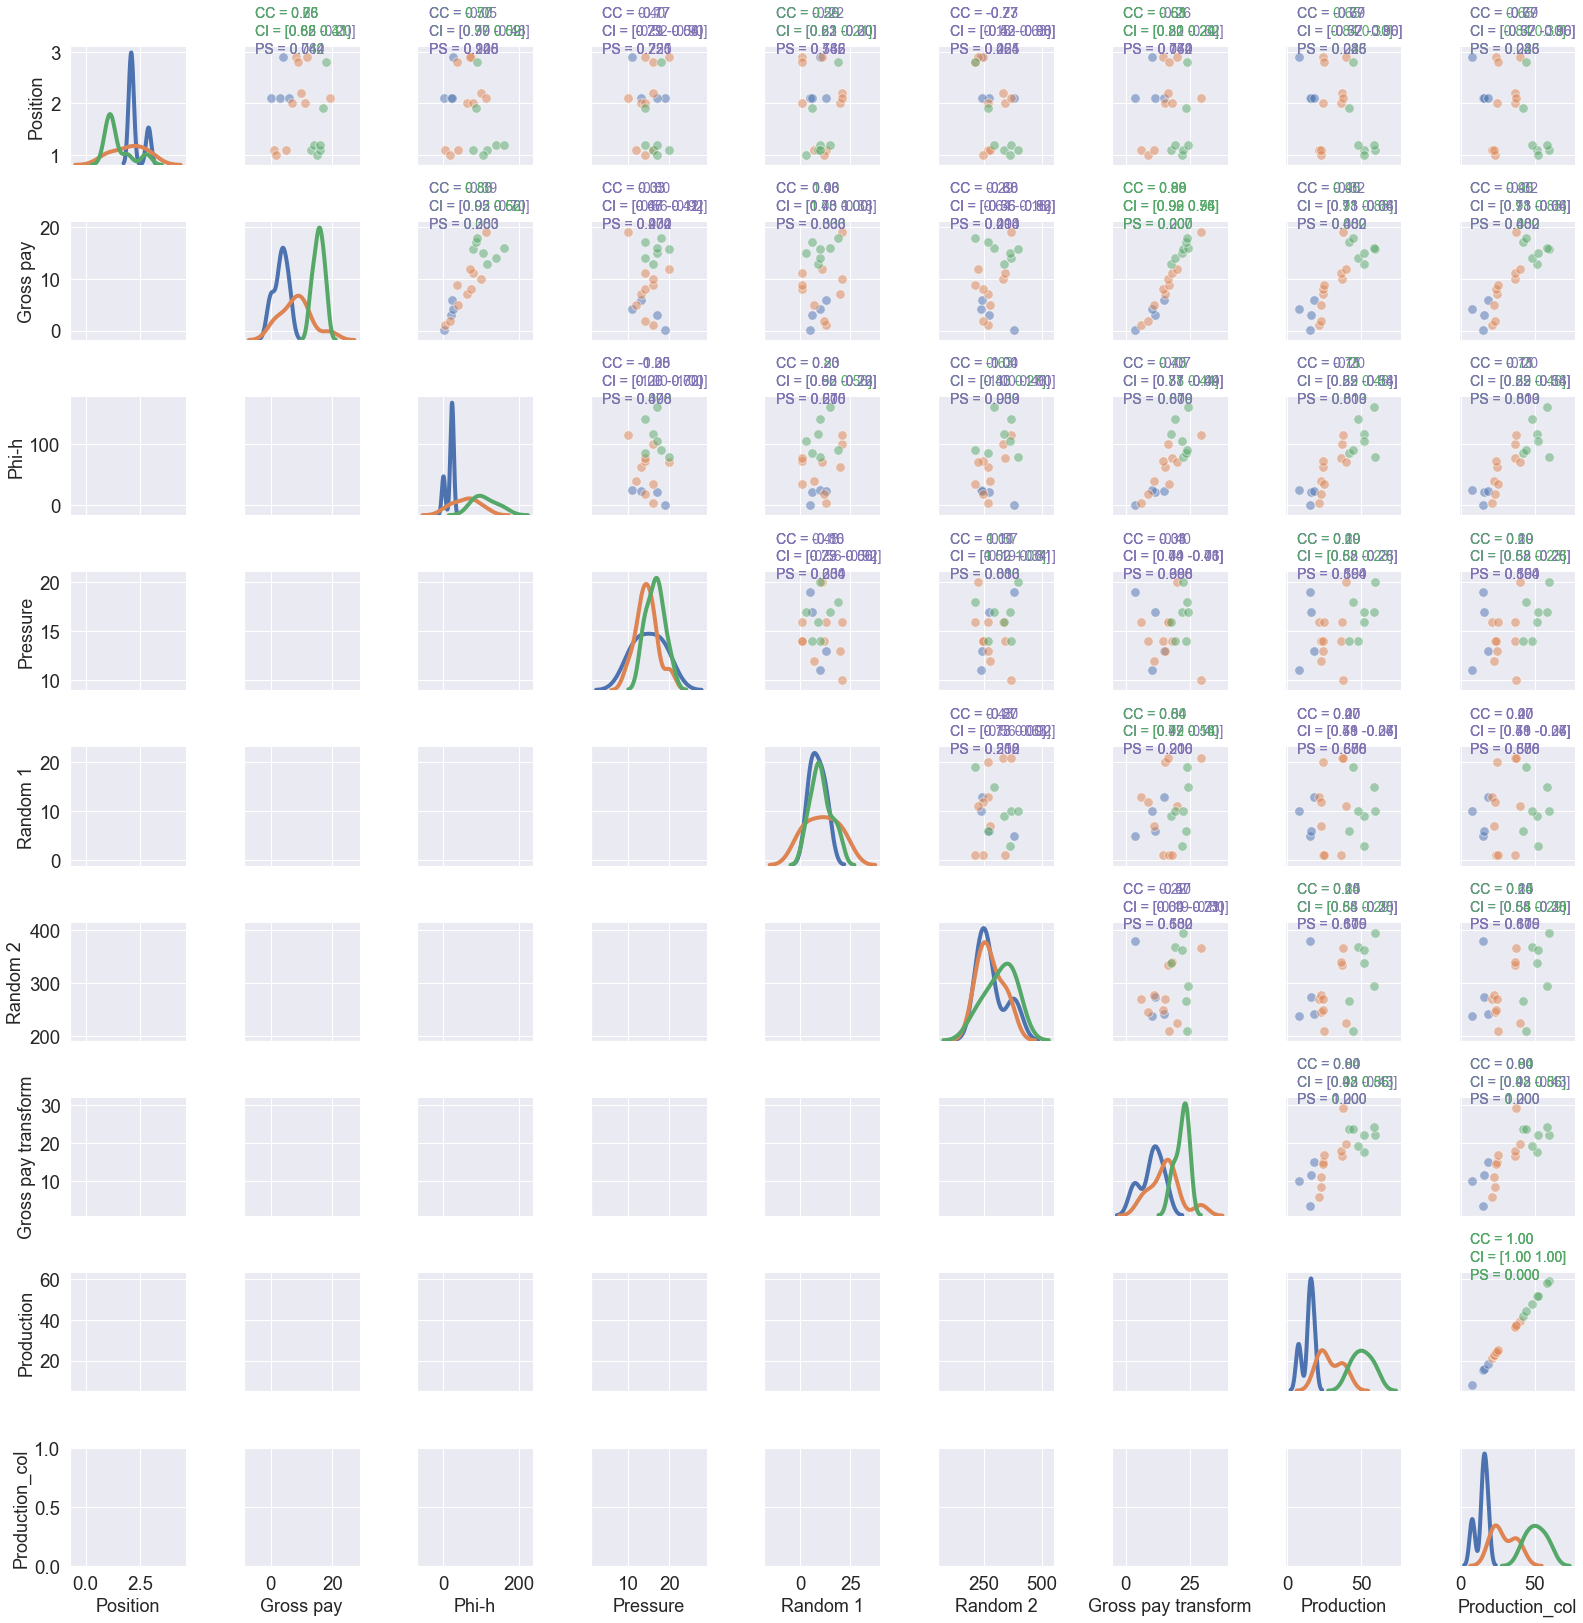

In [47]:
plt.rcParams["axes.labelsize"] = 18
g = sns.PairGrid(data, diag_sharey=False, hue="Production_classes")
axes = g.axes

g.map_upper(plt.scatter,  linewidths=1, edgecolor="w", s=90, alpha = 0.5)
g.map_upper(corrfunc)

g.map_diag(sns.kdeplot, lw = 4, legend=False)
#g.map_lower(sns.kdeplot, cmap="Blues_d")

#plt.savefig('matrix_final.png', dpi=500, bbox_inches='tight', pad_inches=0.1)
plt.show()